In [1]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from resnet import ResNet18, ResNet18Improved
from network_func import *
from optimizer import *
from training import *
from useful_functions import *
from CIFAR10_data_preparation import *

第一个，至少分布式运行的时候没有出现梯度爆炸

注意，这里我已经换了数据

这里：新的数据，旧的模型，旧的训练函数

没有爆炸，说明数据没有问题

目前尚不确定这个组合是否可以跑到sota

In [2]:
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
#A,C=di_ring(n=n)
#B=get_B(A=A,u=2*n,n=n)
A,B=R,R
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=cifar10_prepare_node_5_hard_shuffled()

A的第二大特征值: 4.790584196710678e-25
A的beta: 1.387778780781446e-16
A的spectral gap: 0.9999999999999999
A的kappa: 1.0000000000000002
S_A是: 4.472135954999581 

1.0000e+00, 5.0000e+00


In [7]:
import torch
from torchvision.models import ResNet, resnet18
from torchvision.models import resnet18

def compute_accuracy_with_average_model_resnet18(model_list, X_test, y_test, batch_size=100):
    # 确保 X_test 和 y_test 在相同的设备上
    device = next(model_list[0].parameters()).device

    # Step 1: Compute the average of the parameters from all models
    avg_model = resnet18(num_classes=10).to(device)  # 创建新的模型实例，并将其移动到同一设备上
    avg_state_dict = avg_model.state_dict()  # 获取新模型的状态字典

    # 初始化 sum_state_dict
    sum_state_dict = {key: torch.zeros_like(param).to(device) for key, param in avg_state_dict.items()}

    # 汇总所有模型的参数
    for model in model_list:
        state_dict = model.state_dict()
        for key in sum_state_dict.keys():
            sum_state_dict[key] += state_dict[key].to(device)

    # 计算平均值
    num_models = len(model_list)
    avg_state_dict = {key: value / num_models for key, value in sum_state_dict.items()}

    # 将平均参数加载到新模型中
    avg_model.load_state_dict(avg_state_dict)

    # 确保测试数据在正确的设备上
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    # Step 2: Create test DataLoader with batch_size=100
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Step 3: Evaluate the new model's accuracy using test_loader
    avg_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = avg_model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total

    return accuracy

optimizer初始化成功!


Training Progress: 100%|██████████| 50/50 [16:29<00:00, 19.78s/it, epoch=50, loss=0.0005135864, test_accuracy=54.5700000000%, trian_accuracy=99.8280000000%]


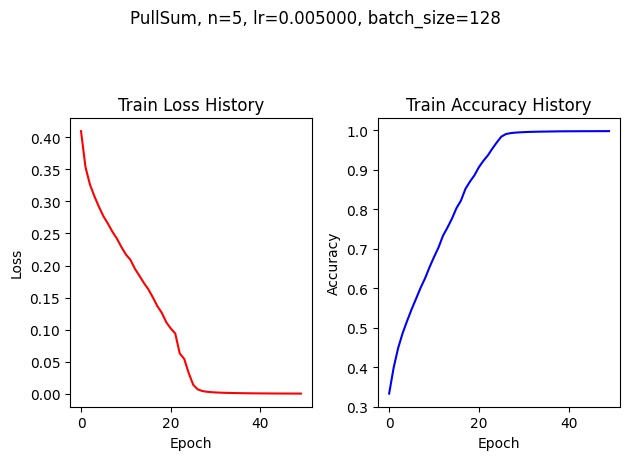

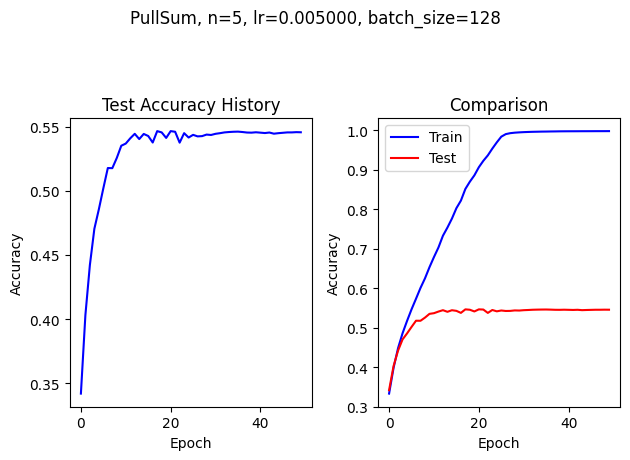

In [14]:
from torchvision.models import resnet18
model_class = lambda: resnet18(num_classes=10)

Sum_l1, Sum_a1 = new_train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=model_class,#SimpleResNet1,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=50,
    lr=1e-3,
    batch_size=128,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model_resnet18,
    show_graph=True
)

第二个，至少分布式运行的时候没有出现梯度爆炸

这里：新的数据，新的模型，旧的训练函数

没有爆炸，说明数据没有问题

目前尚不确定这个组合是否可以跑到sota

In [2]:
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=cifar10_prepare_node_5_hard_shuffled()

A的第二大特征值: 0.7360318786212677
A的beta: 0.810217360924142
A的spectral gap: 0.18978263907585802
A的kappa: 2.000000000000005
S_A是: 39.898193112709905 

1.8413e+00, 2.7000e+01


In [3]:
import torch
from torchvision.models import ResNet, resnet18

def CA_Resnet18(model_list, X_test, y_test, batch_size=100):
    # 确保 X_test 和 y_test 在相同的设备上
    device = next(model_list[0].parameters()).device

    # Step 1: Compute the average of the parameters from all models
    avg_model = ResNet18().to(device)  # 创建新的模型实例，并将其移动到同一设备上
    avg_state_dict = avg_model.state_dict()  # 获取新模型的状态字典

    # 初始化 sum_state_dict
    sum_state_dict = {key: torch.zeros_like(param).to(device) for key, param in avg_state_dict.items()}

    # 汇总所有模型的参数
    for model in model_list:
        state_dict = model.state_dict()
        for key in sum_state_dict.keys():
            sum_state_dict[key] += state_dict[key].to(device)

    # 计算平均值
    num_models = len(model_list)
    avg_state_dict = {key: value / num_models for key, value in sum_state_dict.items()}

    # 将平均参数加载到新模型中
    avg_model.load_state_dict(avg_state_dict)

    # 确保测试数据在正确的设备上
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    # Step 2: Create test DataLoader with batch_size=100
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Step 3: Evaluate the new model's accuracy using test_loader
    avg_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = avg_model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total

    return accuracy

In [4]:
import pandas as pd

# 初始化生成器对象
generator = new_train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=ResNet18,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=50,
    lr=1e-3,
    batch_size=128,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=CA_Resnet18,
    show_graph=True
)

df_history = pd.DataFrame(columns=["epoch", "train_loss", "train_accuracy", "test_accuracy"])

# 使用for循环逐步迭代，每个epoch结束后更新
for epoch, (train_loss_history, train_accuracy_history, test_accuracy_history) in enumerate(generator, start=1):
    # 获取当前epoch的最新数据
    Sum_l2 = train_loss_history[-1]  # 获取当前 epoch 的训练损失
    Sum_a2 = test_accuracy_history[-1]  # 获取当前 epoch 的测试集准确率
    Sum_train_acc = train_accuracy_history[-1]  # 获取当前 epoch 的训练集准确率

    # 将当前 epoch 的数据创建为 DataFrame
    current_epoch_data = pd.DataFrame({
        "epoch": [epoch],
        "train_loss": [Sum_l2],
        "train_accuracy": [Sum_train_acc],
        "test_accuracy": [Sum_a2]
    })

    # 使用 pd.concat 合并 DataFrame
    df_history = pd.concat([df_history, current_epoch_data], ignore_index=True)

    # 打印当前 epoch 的结果
    #print(f"Epoch {epoch} 结束: 训练损失 = {Sum_l2}, 训练集准确率 = {Sum_train_acc}, 测试集准确率 = {Sum_a2}")

    # 每个 epoch 后保存 DataFrame 到本地
    df_history.to_csv("/root/GanLuo/PullSum_MNIST/code/神经网络实验/CIFAR10最终实验/数据保存/training_history.csv", index=False)

/root/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


optimizer初始化成功!


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]